## Disease Entity Tagging: Constructing Labeling Functions

In [14]:
%load_ext autoreload
%autoreload 2

import re
import os
import sys
import bz2
import cPickle
import itertools
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ddlite import *
from datasets import *
#from lexicons import AllUpperNounsMatcher,RuleTokenizedDictionaryMatch

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20,6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Load Precomputed Candidates

In [3]:
candidates = Entities("examples/cache/pmc-disease-candidates-5000.pkl")

In [4]:
model = CandidateModel(candidates)
msg = "Extracted {} features for each of {} mentions"
print msg.format(model.num_feats(), model.num_candidates())

Extracted 1481583 features for each of 96870 mentions


In [23]:
model.open_mindtagger(num_sample=1000, width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


In [5]:
#model.add_mindtagger_tags()
gold_labels = np.load(open("mindtagger_labels","rb"))
model.set_gold_labels(gold_labels)
model.set_holdout()

In [15]:
# stopwords
dictfile = "datasets/dictionaries/chemdner/stopwords.txt"
stopwords = [line.strip().split("\t")[0] for line in open(dictfile).readlines()]

dictfile = "datasets/dictionaries/umls/umls_disease_syndrome.bz2"
diseases = {line.strip().split("\t")[0]:1 for line in bz2.BZ2File(dictfile, 'rb').readlines()}
diseases = {word:1 for word in diseases if word not in stopwords}

In [16]:
measure_words = dict.fromkeys(["mg","ml","mm","cm","grams"])
kw = set(['high-grade', 'acute','progression', 'incidence', 'prevalence', 'diagnosis'])
vague = set(["disease","disorder","infection","defect","condition","syndrome"])

TRUE,FALSE,ABSTAIN = 1,-1,0

def post_window(m, n=3, match_attrib='lemmas'):
    s = list(m.idxs)
    b = len(m.lemmas) - np.max(s)
    s.extend([np.max(s) + i for i in range(1, min(b,n+1))])
    #return [m.__dict__[match_attrib][i] for i in s]
    return [m.lemmas[i] for i in s]

def pre_window(m, n=3, match_attrib='lemmas'):
    s = list(m.idxs)
    b = np.min(s)
    s.extend([b - i for i in range(1, min(b,n+1))])
    #return [m.__dict__[match_attrib][i] for i in s]
    return [m.lemmas[i] for i in s]

def contains(m, word):
    return word in [m.lemmas[i] for i in m.idxs]


#def LF_treats(m):
#    return 1 if 'treats' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0

#def LF_causes(m):
#    return 1 if 'causes' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0


#
# High-precision / Low-conflict Rules
#
def LF_in_list(m):
    '''Candidate co-occurs with several other candidates in parent sentence'''
    n = 0
    idxs = list(m.idxs)
    words = [m.words[i] for i in idxs]
    for i in range(0,len(words)):
        for j in range(i+1,len(words)):
            phrase = " ".join(words[i:j+1])
            if phrase in diseases:
                n +=1
    return TRUE if n > 2 else ABSTAIN

def LF_measurement(m):
    '''Unit of measurement, e.g., 10 gm, 1.2 cm, etc.'''
    mention = " ".join([m.words[i] for i in m.idxs])
    if mention.lower() in measure_words:
        if sum([1 if re.search("\d+[.]*\d*",word) else 0 for word in pre_window(m,3)]) > 0:
            return FALSE 
    return ABSTAIN

def LF_long_phrase(m):
    '''Longer dictionary matches correlate with higher confidence in matches'''
    return TRUE if len(list(m.idxs)) > 2 else ABSTAIN

def LF_short_phrase(m):
    '''Short matches (1-2 characters) are usually wrong'''
    phrase = " ".join([m.lemmas[i] for i in m.idxs])
    return FALSE if len(phrase) <= 2 else ABSTAIN

# terminology-specific features
def LF_keyword_context_match(m):
    return TRUE if kw.intersection(post_window(m)) or kw.intersection(pre_window(m)) else ABSTAIN

def LF_too_vague(m):
    phrase = " ".join([m.lemmas[i] for i in m.idxs])
    return FALSE if phrase in vague else ABSTAIN

def LF_its_cancer(m):
    phrase = " ".join([m.lemmas[i] for i in m.idxs])
    return TRUE if "cancer" in phrase else ABSTAIN

def LF_et_al(m):
    '''Deal with "et al" matches'''
    return FALSE if 'et' in pre_window(m,1) else ABSTAIN 

def LF_noun_phrases(m):
    '''Noun phrase of form JJ|NN[P]* and at least 2 tokens'''
    pos_tags = [m.poses[i] for i in m.idxs]
    w = sum([1 if re.search("^(NN[P]*|JJ)$",tag) else 0 for tag in pos_tags])
    return TRUE if w==len(m.idxs) and len(m.idxs) > 1 else ABSTAIN

#
# Low-precision / High-coverage
#

In [24]:
LFs = [LF_in_list,LF_keyword_context_match,LF_long_phrase,LF_et_al,LF_measurement,
       LF_noun_phrases,LF_its_cancer,LF_too_vague,LF_short_phrase]
model.apply_lfs(LFs, clear=True)

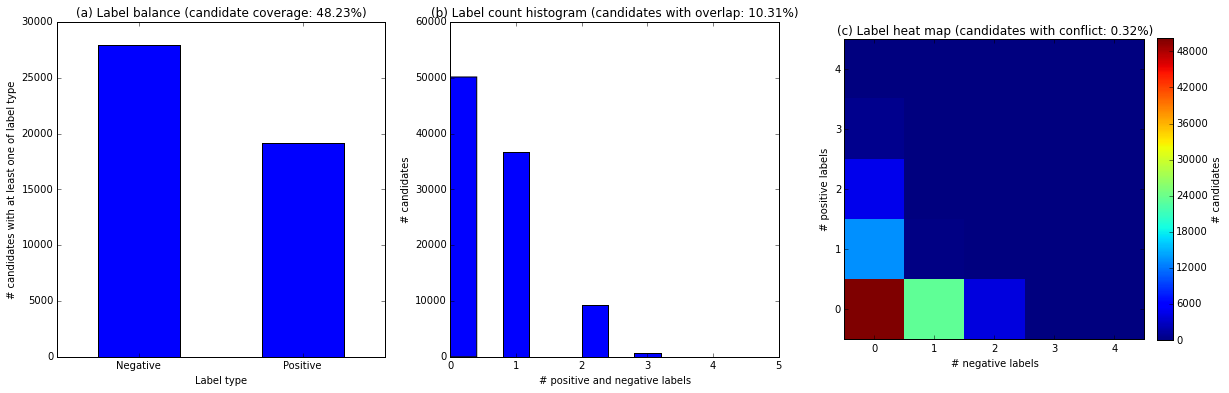

In [25]:
model.plot_lf_stats()

In [26]:
labels = model.get_ground_truth()
np.save(open("/users/fries/desktop/mindtagger_labels.npy","w"),labels)

In [27]:
model.top_conflict_lfs(n=10)

Labeling function,Fraction of candidates where LF has conflict
LF_keyword_context_match,0.003
LF_short_phrase,0.002
LF_too_vague,0.002
LF_measurement,0.000
LF_et_al,0.000
LF_in_list,0.000
LF_noun_phrases,0.000
LF_long_phrase,0.000
LF_its_cancer,0.000


In [28]:
model.lowest_coverage_lfs(n=10)

Labeling function,Fraction of abstained votes
LF_in_list,0.998
LF_measurement,0.986
LF_its_cancer,0.978
LF_et_al,0.971
LF_keyword_context_match,0.970
LF_long_phrase,0.960
LF_too_vague,0.950
LF_noun_phrases,0.834
LF_short_phrase,0.762


In [29]:
model.lowest_empirical_accuracy_lfs(n=10)

Labeling function,Empirical LF accuracy
LF_keyword_context_match,0.750 (n=20)
LF_noun_phrases,0.865 (n=74)
LF_too_vague,0.913 (n=23)
LF_short_phrase,0.937 (n=95)
LF_long_phrase,0.960 (n=25)
LF_in_list,1.000 (n=2)
LF_measurement,1.000 (n=8)
LF_et_al,1.000 (n=11)
LF_its_cancer,1.000 (n=10)


In [32]:
matplotlib.rcParams['figure.figsize'] = (12,4)
%time model.learn_weights(sample=False, maxIter=500, mu=5e-4, alpha=0.5, verbose=True, plot=True, log=True)

Learning epoch =  0	100	200	300	400	
CPU times: user 1min 41s, sys: 21.8 s, total: 2min 3s
Wall time: 2min 4s


<ddlite.ddlite.ModelLog instance at 0x158aaef80>

In [33]:
model.show_log()

ID,# LFs,# ground truth,Precision,Recall,F1
0,9,458,0.860,0.909,0.884
1,9,458,0.860,0.909,0.884


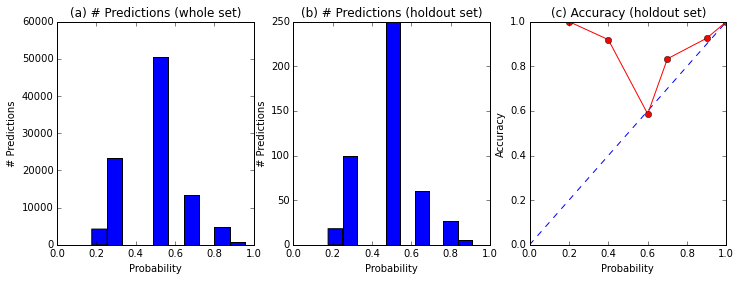

In [34]:
model.plot_calibration()